# METEHAN AYHAN - SENTİMENT ANALYSİS PROJECT WİTH NLP

Bu projenin amacı, Yelp, Foursquare ve Twitter gibi platformlardan toplanan müşteri yorumlarını analiz ederek Bacchanal Buffet için müşteri memnuniyetini artıracak öneriler sunmaktır. Bu amaçla, doğal dil işleme (NLP) teknikleri kullanılarak yorumların duygu analizleri yapılacaktır.

<img src='https://assets.simpleviewcms.com/simpleview/image/fetch/c_pad,h_600,q_75,w_1122/https://lasvegas.simpleviewcrm.com/images/listings/original_Bacchanal-Buffet-at-Caesars-Palace.jpg' width='500'>

### Data Dictionary

- review_id: Her bir yorumun benzersiz kimliğini (ID) ifade eder.

- user_id: Yorumu yapan kullanıcının benzersiz kimliğidir.

- business_id: Yoruma konu olan işletmenin benzersiz kimliğini ifade eder.

- stars: Yorumu yapan kullanıcının işletmeye verdiği yıldız puanını belirtir.

- useful: Başka kullanıcıların bir yorumu faydalı bulup bulmadığını gösterir. Bu sayı, kaç kullanıcının yorumu "faydalı" olarak işaretlediğini gösterir.

- funny: Başka kullanıcıların bir yorumu komik bulup bulmadığını gösterir.

- cool: Başka kullanıcıların bir yorumu havalı bulup bulmadığını gösterir.

- text: Yorumu yapan kullanıcının yazdığı metindir.

- date: Yorumu yapan kullanıcının yorumunu ne zaman yazdığını gösterir.

In [14]:
#pip install stylecloud

In [15]:
#pip install langdetect

### Import Packet

In [16]:
import pandas as pd
import seaborn as sns
import stylecloud as sc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import string
from langdetect import detect, DetectorFactory
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [17]:
df=pd.read_csv('restaurant.csv')

In [18]:
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,2370338,_WTGv5XnA-qb_XD1D7Z0jg,6PgdGb3HrZdsfl2GiULo8w,RESDUcs7fIiihp38-d6_6g,5,0,1,0,After getting food poisoning at the Palms hote...,2012-12-04 03:10:18
1,2370357,JlNnsvMPLK_1-X2hwzK24w,IS9yw8P2uAPBX6FNLLX4KA,RESDUcs7fIiihp38-d6_6g,4,39,21,29,"""A feast worthy of Gods""\n\nBaccarnal Buffet i...",2014-01-17 00:50:50
2,2370373,hBkoWffORRb6aqKhC_Li2A,uZdFsE_aHbFBChgN6Xa8tw,RESDUcs7fIiihp38-d6_6g,4,1,1,1,The crab legs are better than the ones at Wick...,2015-06-08 18:03:09
3,2370411,rbkxvrgZg5kdCL2a66QYmA,8ZWJNAEWsymXDzKx3B0tTQ,RESDUcs7fIiihp38-d6_6g,1,0,0,0,Not worth it! Too salty food and expensive! Th...,2016-12-19 16:15:29
4,2370500,5tw_pedoHVi9bgeiBNsISg,E0sm4Ve7ifanFYeQMcV8Eg,RESDUcs7fIiihp38-d6_6g,5,0,0,0,I would give this infinite stars if I could. M...,2015-07-28 07:13:17


### EDA - Exploratory Data Analysis

In [19]:
df.columns

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date'],
      dtype='object')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10417 entries, 0 to 10416
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   10417 non-null  int64 
 1   review_id    10417 non-null  object
 2   user_id      10417 non-null  object
 3   business_id  10417 non-null  object
 4   stars        10417 non-null  int64 
 5   useful       10417 non-null  int64 
 6   funny        10417 non-null  int64 
 7   cool         10417 non-null  int64 
 8   text         10417 non-null  object
 9   date         10417 non-null  object
dtypes: int64(5), object(5)
memory usage: 814.0+ KB


In [21]:
df.shape

(10417, 10)

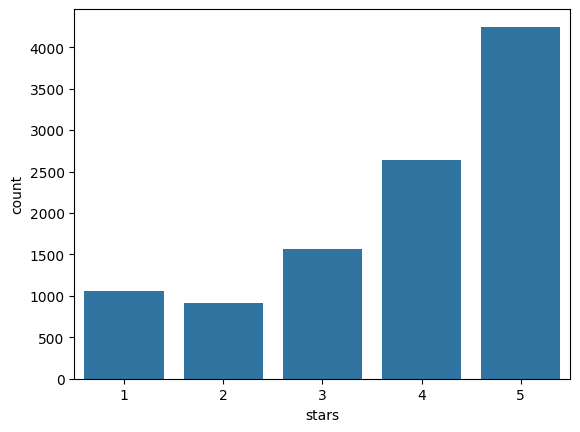

In [22]:
sns.countplot(x=df["stars"]);

In [23]:
df.describe()

,Unnamed: 0,stars,useful,funny,cool
count,1.041700e+04,10417.000000,10417.000000,10417.000000,10417.000000
mean,2.775377e+06,3.777671,1.419603,0.640875,0.759720
std,2.428654e+05,1.331451,4.875888,3.347964,4.125847
min,2.370338e+06,1.000000,0.000000,0.000000,0.000000
25%,2.566392e+06,3.000000,0.000000,0.000000,0.000000
50%,2.762536e+06,4.000000,0.000000,0.000000,0.000000
75%,2.975480e+06,5.000000,1.000000,0.000000,0.000000
max,3.220316e+06,5.000000,176.000000,159.000000,172.000000


### Data Preprocessing

Öncelikle işimize yaramayacak olan sütunları kaldıralım.

In [24]:
df = df.drop(columns=['Unnamed: 0', 'business_id', 'review_id', 'user_id','date'])


In [25]:
df.head()

,stars,useful,funny,cool,text
0,5,0,1,0,After getting food poisoning at the Palms hote...
1,4,39,21,29,"""A feast worthy of Gods""\n\nBaccarnal Buffet i..."
2,4,1,1,1,The crab legs are better than the ones at Wick...
3,1,0,0,0,Not worth it! Too salty food and expensive! Th...
4,5,0,0,0,I would give this infinite stars if I could. M...


Useful funny ve cool gibi sayısal ifadeleri birleştirelim.

In [26]:
df['numeric'] = df['useful'] + df['funny'] + df['cool']
df = df.drop(columns=['useful', 'funny', 'cool'])

In [27]:
df.head()

,stars,text,numeric
0,5,After getting food poisoning at the Palms hote...,1
1,4,"""A feast worthy of Gods""\n\nBaccarnal Buffet i...",89
2,4,The crab legs are better than the ones at Wick...,3
3,1,Not worth it! Too salty food and expensive! Th...,0
4,5,I would give this infinite stars if I could. M...,0


### Text Processing

In [28]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.translate(str.maketrans('', '', string.punctuation))
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df['text'] = df['text'].str.replace(r'\n', ' ', regex=True)

In [29]:
#ingilizce olmayan kelimeleri kaldıralım

In [30]:
#pip install langdetect

In [31]:
DetectorFactory.seed = 0
df = df[df['text'].apply(lambda x: detect(x) == 'en')]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10373 entries, 0 to 10416
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   stars    10373 non-null  int64 
 1   text     10373 non-null  object
 2   numeric  10373 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 324.2+ KB


In [33]:
#Stopwordsleri kaldıralım.

In [35]:
pip install nltk

In [37]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [40]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [41]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join(word for word in word_tokenize(text) if word.lower() not in stop_words)

df['text'] = df['text'].apply(remove_stopwords)

In [42]:
# Tokenizasyon
df['text'] = df['text'].apply(word_tokenize)

In [45]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [46]:
# Lemmatizasyon
lemmatizer = WordNetLemmatizer()
def lemmatization(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text)
df['text'] = df['text'].apply(lemmatization)

In [47]:
#Duygu etiketleme
def label_sentiment(stars):
    if stars in [1, 2]:
        return 'Negative'
    elif stars == 3:
        return 'Neutral'
    elif stars in [4, 5]:
        return 'Positive'

df['sentiment'] = df['stars'].apply(label_sentiment)

In [48]:
df.head(10)

,stars,text,numeric,sentiment
0,5,getting food poisoning palm hotel scared eat b...,1,Positive
1,4,feast worthy god baccarnal buffet caesar palac...,89,Positive
2,4,crab leg better one wicked spoon huge prawn sh...,3,Positive
3,1,worth salty food expensive furst kast visit bu...,0,Negative
4,5,would give infinite star could family diamond ...,0,Positive
5,5,really enjoyed everything offer good idea star...,0,Positive
6,4,came dinner per person around pm practically l...,0,Positive
7,4,probably one best buffet ive vega located caes...,0,Positive
8,5,lot choice good service line wasnt long expect...,0,Positive
9,3,craving getting buffet long time blame year we...,2,Neutral


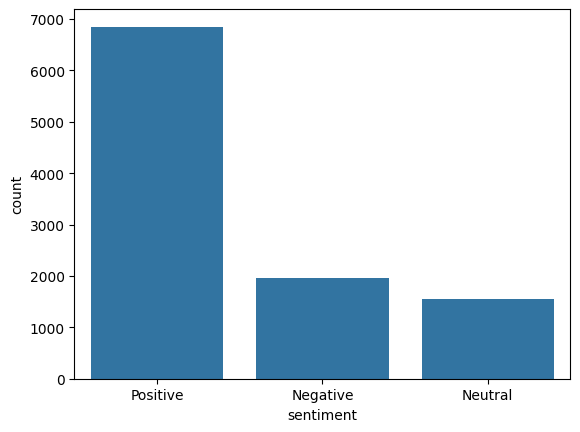

In [49]:
sns.countplot(x=df["sentiment"]);

### Modelling

In [50]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

In [51]:
x=df[['text','numeric']]
y=df[['sentiment']]

In [52]:
vect=CountVectorizer(stop_words='english',ngram_range=(1,2))

In [53]:
xyeni=vect.fit_transform(x['text'])

In [54]:
x_train,x_test,y_train,y_test=train_test_split(xyeni,y,random_state=42,test_size=0.20)

In [55]:
# En iyi modeli belirleyen fonksiyon.

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def classifier(X_train, X_test, y_train, y_test):
    # Modelleri bir listeye ekleyelim
    models = {
        'LogisticRegression': LogisticRegression(),
        'KNeighborsClassifier': KNeighborsClassifier(),
        'DecisionTreeClassifier': DecisionTreeClassifier(),
        'RandomForestClassifier': RandomForestClassifier(),
        'AdaBoostClassifier': AdaBoostClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier(),
        'MultinomialNB': MultinomialNB(),
        'BernoulliNB': BernoulliNB()
    }

    # Sonuçları tutmak için bir liste
    results = []

    for model_name, model in models.items():
        # Modeli eğit
        model.fit(X_train, y_train)
        # Tahmin yap
        y_pred = model.predict(X_test)
        # Performans metriklerini hesapla
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Sonuçları sakla
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

    # Sonuçları DataFrame'e dönüştür
    results_df = pd.DataFrame(results)
    return results_df


In [57]:
#sonuclar = classifier(x_train, x_test, y_train, y_test)
#sonuclar

In [58]:
#En iyi doğruluk LogisticRegression'da çıktı.

In [59]:
lr=LogisticRegression()

In [60]:
model=lr.fit(x_train,y_train)

In [61]:
pred=model.predict(x_test)

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [63]:
conf_matrix = confusion_matrix(y_test, pred, labels=['Negative', 'Neutral', 'Positive'])

In [64]:
accuracy_score(y_test,pred)

0.8048192771084337

In [65]:
precision_score(y_test,pred, average='weighted')

0.7838625012153093

In [66]:
recall_score(y_test,pred, average='weighted')

0.8048192771084337

In [67]:
f1_score(y_test,pred, average='weighted')

0.7889970951885138

In [68]:
# yorumların duygusunu  %80 doğru analiz eden model geliştirildi.

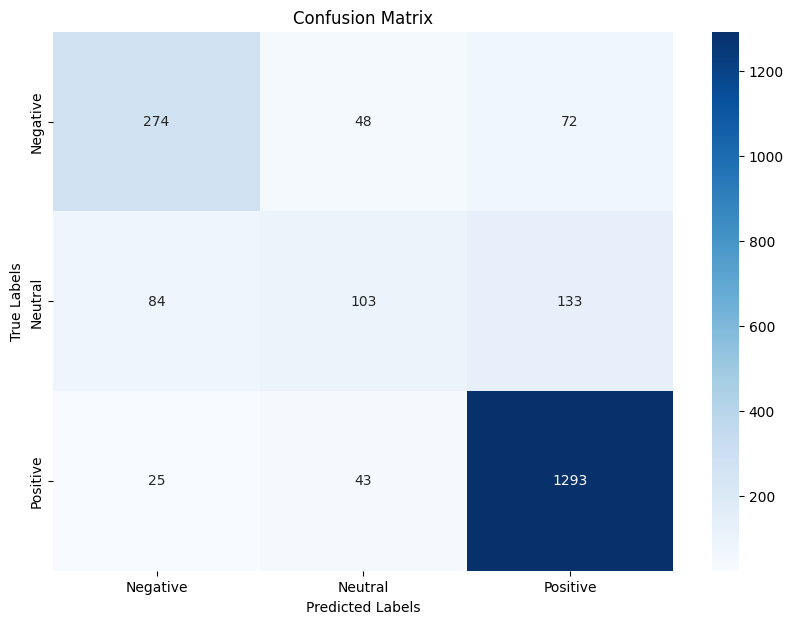

In [69]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Results

In [79]:
#pip install stylecloud

In [92]:
def wc(data,bgcolor,filename):
    from PIL import Image
    mask = np.array(Image.open("cloud.png"))
    wc=WordCloud(background_color=bgcolor, width=800, height=400,mask=mask,max_words=300).generate(' '.join(data))
    plt.figure( figsize=(20,10) )
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    wc.to_file(filename)

In [93]:
negatif_data=df[df['sentiment']=="Negative"]['text']
pozitif_data=df[df['sentiment']=="Positive"]['text']
notr_data=df[df['sentiment']=="Neutral"]['text']


In [94]:
pozitif_data.head()

,text
0,getting food poisoning palm hotel scared eat b...
1,feast worthy god baccarnal buffet caesar palac...
2,crab leg better one wicked spoon huge prawn sh...
4,would give infinite star could family diamond ...
5,really enjoyed everything offer good idea star...


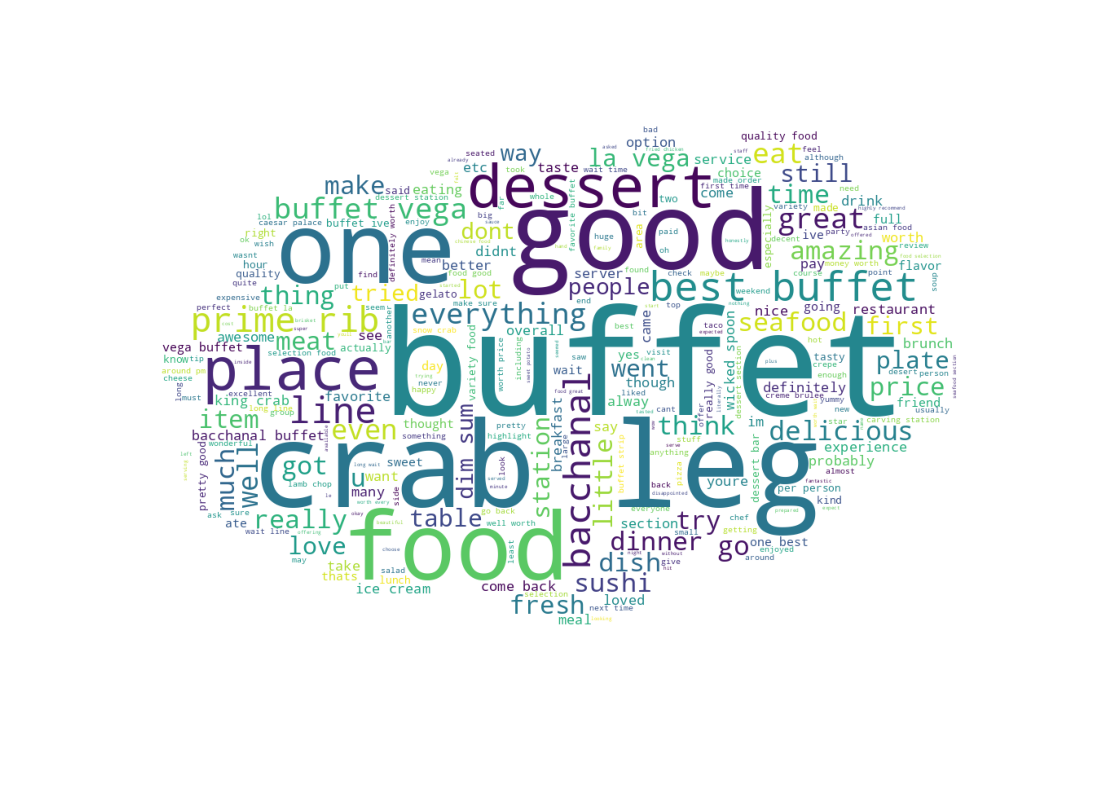

In [95]:
wc(pozitif_data,'white','pozitif.png')

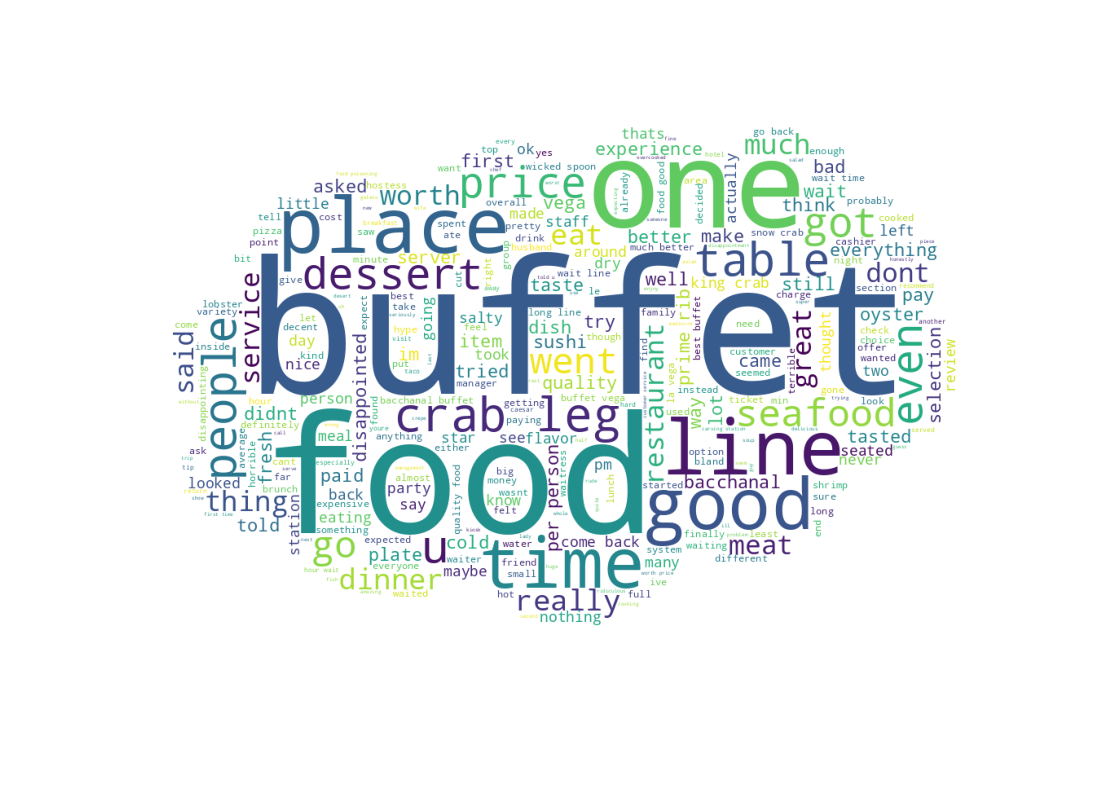

In [96]:
wc(negatif_data,'white','negatif.png')

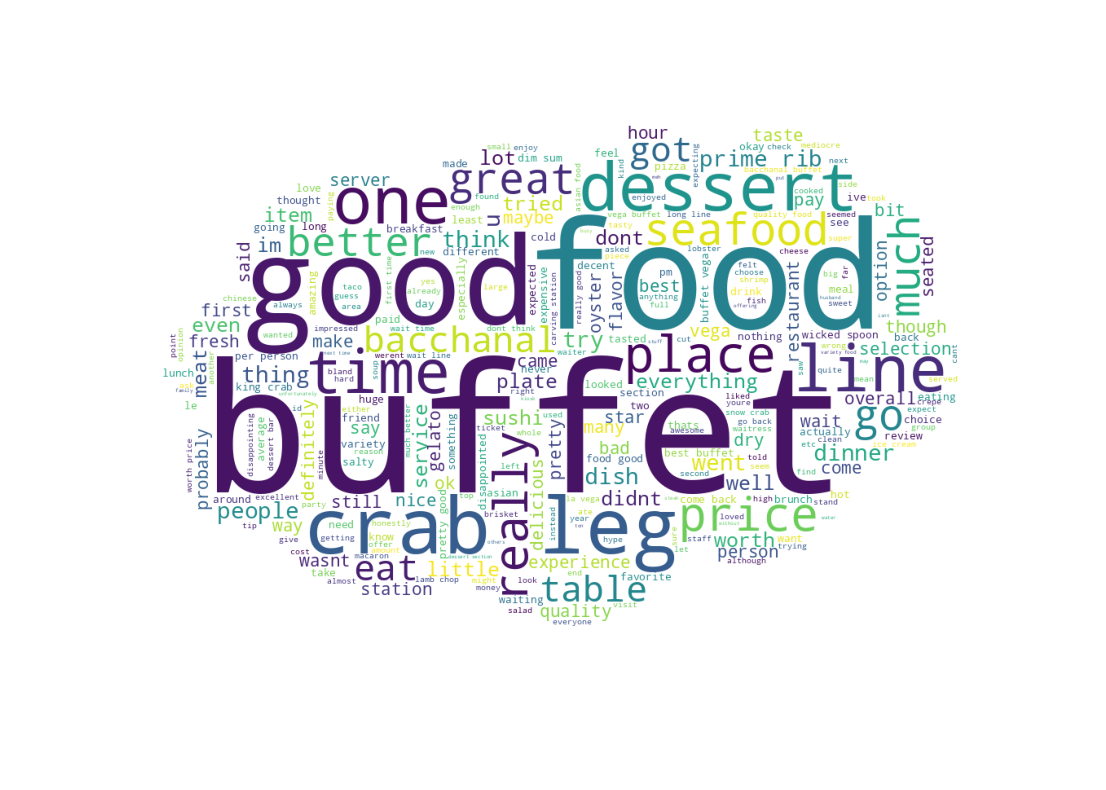

In [97]:
wc(notr_data,'white','notr.png')